In [2]:
import os
import sys
import glob
import hashlib

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy

from rdkit import Chem
from rdkit.Chem import AllChem

from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (300, 300)   # Change image size
IPythonConsole.ipython_useSVG = True  # Change output to SVG
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.minFontSize = 18
IPythonConsole.drawOptions.prepareMolsBeforeDrawing = True

In [3]:
# config
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({'font.size': 22})

# Change Matplotlib font to Helvetica
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.legend_handler import HandlerTuple

mpl.rcParams['font.family'] = 'Helvetica'
fm.findfont("Helvetica", fontext="ttx", rebuild_if_missing=False)

'/System/Library/Fonts/Helvetica.ttc'

In [4]:
base_dir = os.path.dirname(os.path.realpath('__file__')).replace('/scripts/hydrolysis', '')
base_dir

'/Users/nicolairee/KU_data/esnuelML/ESNUEL_ML'

In [5]:
sys.path.append(os.path.join(base_dir, 'src/esnuelML'))
from DescriptorCreator.GraphChargeShell import GraphChargeShell
from DescriptorCreator.NodeDescGenerator import NodeDescGenerator
from predictor import run_MAA_and_MCA_predictions, pred_MAA_and_MCA, elec_model

SQM folder is: 
/Users/nicolairee/KU_data/esnuelML/ESNUEL_ML/desc_calcs


/Users/nicolairee/opt/miniforge3/envs/alfabet/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nicolairee/opt/miniforge3/envs/alfabet/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Functions

In [6]:
def remove_identical_atoms(rdkit_mol, atom_list):
    idx_list = []
    rank_kept = []
    atom_rank = list(Chem.CanonicalRankAtoms(rdkit_mol, breakTies=False))
    for idx, atom in enumerate(atom_list):
        if atom_rank[atom] not in rank_kept:
            rank_kept.append(atom_rank[atom])
            idx_list.append(idx)
    
    atom_list = np.array(atom_list)[idx_list].tolist()
    return atom_list

# public_hydrolysis_data_tebes_stevens

In [7]:
df = pd.read_csv(os.path.join(base_dir, 'data/hydrolysis/from_sources/public_hydrolysis_data_tebes_stevens_pcpUpdated.csv'))
print(df.shape)

selected_pH = 'ph7'
# selected_pH = 'ph9'

df_subset = df[~df[selected_pH].isna()].drop_duplicates('name')
df_subset = df_subset[~(df_subset.smiles.isna()) | ~(df_subset.pcp_smiles.isna())]
print(df_subset.shape[0])

(187, 8)
144


In [8]:
pkl_files = glob.glob(f'/Users/nicolairee/KU_data/hydrolysis/public_hydrolysis_data/*result.pkl')

calc_failed = []
df_res = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    
    d = pd.read_pickle(f)

    if d[0] == 'error':
        calc_failed.append(f)
    else:
        df_res = df_res._append(d[-1], ignore_index=True, sort=False)

print(df_res.shape[0])
df_res.head(2)

157


,name,smiles,elec_sites,elec_names,elec_prod_smis,MAA_values,MAA_calc_logs,nuc_sites,nuc_names,nuc_prod_smis,MCA_values,MCA_calc_logs
0,20,C=CCI,"[[0, 1]]","[[double_bond, double_bond]]","[[CC[CH-]CI, [CH2-]C(C)CI]]","[[292.7163323897403, 146.12182870088145]]","[[[[None, '20/reac01/conf04/gfn1/20_reac01_con...","[[0, 1, 3]]","[[double_bond, double_bond, atom_with_lone_pair]]","[[CC[CH+]CI, [CH2+]C(C)CI, C=CC[I+]C]]","[[373.8444553350564, 399.726496482268, 300.145...","[[[[None, '20/reac01/conf04/gfn1/20_reac01_con..."
1,125,CNC(=O)Oc1cccc2c1OC(C)(C)C2,"[[2, 3, 5, 6, 7, 8, 9, 10]]","[[Ester, double_bond, double_bond, double_bond...","[[CNC(C)([O-])Oc1cccc2c1OC(C)(C)C2, CN[C-](OC)...","[[269.0738586683292, -88.40286510251462, 290.9...","[[[[None, '125/reac01/conf10/gfn1/125_reac01_c...","[[11, 1, 2, 5, 6, 7, 8, 9, 10, 3, 4]]","[[Ether, Amine, double_bond, double_bond, doub...","[[CNC(=O)Oc1cccc2c1[O+](C)C(C)(C)C2, C[NH+](C)...","[[288.8969936403446, 366.92634644336067, 282.2...","[[[[None, '125/reac01/conf10/gfn1/125_reac01_c..."


In [9]:
print(calc_failed)

['/Users/nicolairee/KU_data/hydrolysis/public_hydrolysis_data/43071379_2_0_result.pkl', '/Users/nicolairee/KU_data/hydrolysis/public_hydrolysis_data/42470180_44_0_result.pkl']


In [10]:
path = '/Users/nicolairee/Desktop/steno/PhD/applications/ESNUEL/hydrolysis/testmols/calculations'

smarts_of_interest = Chem.MolFromSmarts('[#6]([#6,#7])(=[OX1])[#8][#6]') # Esters, "Amides"
# smarts_of_interest = Chem.MolFromSmarts('[#6]([#6])(=[OX1])[#8][#6]') # Esters
# smarts_of_interest = Chem.MolFromSmarts('[#6]([#6,#7,#8])(=[OX1])[#8;$([#8]([#6])[#6]),$([#8H1][#6])]') # Esters extended
# smarts_of_interest = Chem.MolFromSmarts('[#6]=[OX1]') # Carbonyl carbons
# smarts_of_interest = Chem.MolFromSmarts('*') # Any

DT50val_list = []
calc_maa_list = []
pred_maa_list = []
pred_maa_error_list = []

name_list = []
smiles_list = []
rdkit_mol_list = []
errors_list = []
for idx, row in df_res.iterrows():
    name = row['name']
    elec_names = np.array(row['elec_names'][0])
    elec_sites = np.array(row['elec_sites'][0])
    MAA_values = np.array(row['MAA_values'][0])

    smiles = row['smiles']
    rdkit_mol = Chem.MolFromSmiles(smiles)
    rdkit_molHs = Chem.AddHs(rdkit_mol)

    if name not in df_subset['id'].tolist() or len(row['MAA_calc_logs'][0]) == 0:
        continue
    else:
        DT50val = df_subset[df_subset['id'] == name][selected_pH].tolist()[0]

    try:
        if (row['MAA_calc_logs'][0][0][0][0] != None) or (not len(rdkit_mol.GetSubstructMatches(smarts_of_interest))):
            continue
    except:
        display(row)
        break
    
    # Create descriptor vector only for the provided atom sites
    sites_of_interest = list(set(np.array(rdkit_mol.GetSubstructMatches(smarts_of_interest))[:,0]))
    sites_of_interest = remove_identical_atoms(rdkit_molHs, sorted(sites_of_interest))
    # sites_of_interest = elec_sites #<-- all detected sites

    hashID = hashlib.md5(smiles.encode()).hexdigest()
    elec_sites, elec_names, elec_preds, elec_errors, nuc_sites, nuc_names, nuc_preds, nuc_errors = run_MAA_and_MCA_predictions(hashID, smiles)
    
    pred_maa = []
    pred_maa_error = []
    for atom in sites_of_interest:
        index = elec_sites.index(atom)
        pred_maa.append(elec_preds[index])
        pred_maa_error.append(elec_errors[index])

    index_list = [i for i, val in enumerate(elec_sites) if val in sites_of_interest]
    assert len(index_list) == len(pred_maa), f'Length of predicted and calculated sites are different!: {smiles}, {sites_of_interest}, {elec_sites}'

    maa = MAA_values[index_list]
    if len(maa) >= 1:
        print(name, np.array(elec_sites)[index_list], maa, pred_maa)
        DT50val_list.append(float(DT50val))
        calc_maa_list.append(float(max(maa)))
        pred_maa_list.append(float(max(pred_maa)))
        pred_maa_error_list.append(float(pred_maa_error[np.argmax(pred_maa)]))
        
        name_list.append(name)
        smiles_list.append(smiles)
        rdkit_mol.__sssAtoms = [int(sites_of_interest[np.argmax(pred_maa)])]
        rdkit_mol_list.append(rdkit_mol)
        errors_list.append(list(np.array(row['MAA_calc_logs'][0][list(elec_sites).index(sites_of_interest[np.argmax(maa)])])[:,0]))
    else:
        print(name, elec_sites[index_list], maa, pred_maa)

125 [2] [269.07385867] [158.82003501916537]
122 [2] [268.20313416] [156.94721379644793]
186 [ 3 11] [124.3556269  169.87201595] [118.95393746832289, 161.0929660691828]
132 [2] [242.31982173] [120.52589059427277]
105 [1] [250.38715599] [226.88860273265948]
110 [3] [218.7699379] [209.8621266432369]
148 [2] [255.90170577] [118.55817568260031]
96 [8] [160.93087776] [151.59937228790346]
133 [2] [249.1617588] [123.23778766945647]
123 [ 3 12] [136.26394093 179.78720477] [151.04119760770323, 179.2097773687899]
124 [2] [281.10214644] [153.93901517804707]
94 [3] [176.19400283] [166.55688064039876]
104 [8] [249.79417015] [249.61214180746157]
165 [5] [209.49728054] [185.0505374381612]
100 [4] [177.80334194] [168.66804030392436]
131 [2] [279.89968646] [159.8038288126235]
101 [ 2 11] [175.78648427  96.7232592 ] [132.0055112545691, 123.81214117562912]
143 [3] [270.72681256] [140.9083624915684]
146 [23] [262.11141457] [124.44669052242556]
121 [11] [279.00208046] [136.90678248980203]
180 [12] [157.4675

In [11]:
any_errors_list = [any(x) for x in errors_list]
hybrid_maa_list = [pred_maa_list[i] if any_errors_list[i] == True else calc_maa for i,calc_maa in enumerate(calc_maa_list)]

In [12]:
list(zip(*np.unique(any_errors_list, return_counts=True)))

[(False, 14), (True, 15)]

125
CNC(=O)Oc1cccc2c1OC(C)(C)C2
True
269.0738586683292
158.82003501916537


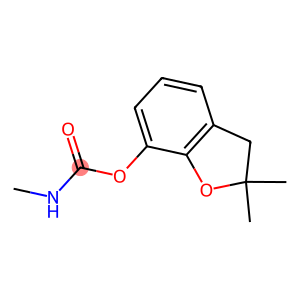

In [13]:
index = 0
print(name_list[index])
print(smiles_list[index])
print(any_errors_list[index])
print(calc_maa_list[index])
print(pred_maa_list[index])
rdkit_mol_list[index]

In [14]:
# x = calc_maa_list
x = np.log10(DT50val_list)
y = pred_maa_list
# y = calc_maa_list
# y = hybrid_maa_list

# x = np.log10([DT50val for i,DT50val in enumerate(DT50val_list) if any_errors_list[i] == False])
# y = [calc_maa for i,calc_maa in enumerate(calc_maa_list) if any_errors_list[i] == False]

# x2 = np.log10([DT50val for i,DT50val in enumerate(DT50val_list) if any_errors_list[i] == True])
# y2 = [calc_maa for i,calc_maa in enumerate(calc_maa_list) if any_errors_list[i] == True]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

print(f'N:\t\t {len(x)}')
print(f'MSE:\t\t {metrics.mean_squared_error(x, y):.2f}')
print(f'RMSE:\t\t {metrics.mean_squared_error(x, y, squared=False):.2f}')
print(f'MAE:\t\t {metrics.mean_absolute_error(x, y):.2f}')
print(f'R^2:\t\t {r_value**2:.2f}')
print(f'Pearsonr:\t {scipy.stats.pearsonr(x, y).statistic:.2f}')
print(f'SpearmanR:\t {scipy.stats.spearmanr(x, y).statistic:.2f}')

N:		 29
MSE:		 28629.87
RMSE:		 169.20
MAE:		 165.38
R^2:		 0.76
Pearsonr:	 -0.87
SpearmanR:	 -0.82


In [15]:
# Error above 30 kJ/mol
error_index = np.where(np.array(pred_maa_error_list) > 30)
x2 = np.array(x)[error_index]
y2 = np.array(y)[error_index]

In [16]:
len(x), len(x2)

(29, 2)

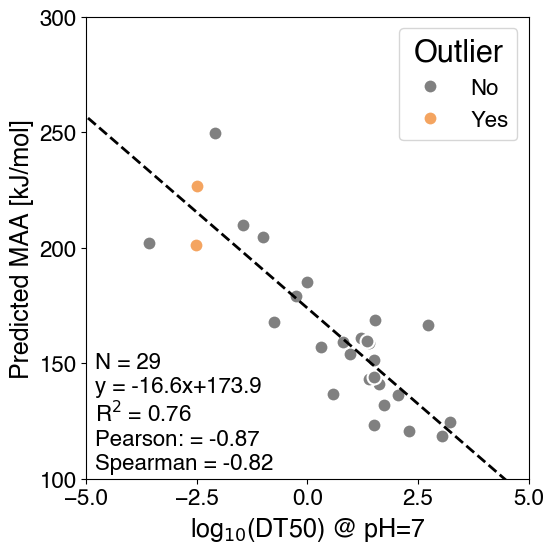

In [17]:
fig = plt.subplots(figsize=(6, 6))
plt.plot(x, y, 'o', color='Gray',  markeredgecolor='White', markeredgewidth=1.5, markersize=10, label='No')
plt.plot(x2, y2, 'o', color='sandybrown', markeredgecolor='White', markeredgewidth=1.5, markersize=10, label='Yes') # Pred
# plt.plot(x2, y2, 'o', color='Gray', markeredgecolor='Tomato', markeredgewidth=1.5, markersize=10, label='Yes') # Calc

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

plt.plot(np.arange(-12,13,1), slope * np.arange(-12,13,1) + intercept, 'Black', linestyle='dashed', lw=2)
plt.text(-4.8, 104, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {scipy.stats.pearsonr(x, y).statistic:.2f} \nSpearman = {scipy.stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)


plt.xlabel('log$_{10}$(DT50) @ pH='+selected_pH.strip('ph'), fontsize=18)
plt.ylabel('Predicted MAA [kJ/mol]', fontsize=18)
# plt.ylabel('Calculated MAA [kJ/mol]', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlim(-5,5)
plt.ylim(100,300)
plt.xticks(np.arange(-5,6,2.5), fontsize=16)
plt.yticks(np.arange(100,301,50), fontsize=16)
plt.legend(loc=1, title='Outlier', fontsize=16)

plt.tight_layout()
plt.savefig('figures/hydrolysisResultsPred.pdf')
# plt.savefig('figures/hydrolysisResultsCalc.pdf')
plt.show()

In [30]:
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

# Create SVGs for each smiles
imgs = [mol._repr_svg_() for mol in rdkit_mol_list]

# Configure for output in the notebook
output_notebook()

# Load the data into a source and plot
source = ColumnDataSource(
    data={
        "x": x,
        "y": y,
        "imgs": imgs,
        "name": name_list,
        "smiles": smiles_list,
        "errors": any_errors_list,
        # "imgs": [img for i,img in enumerate(imgs) if any_errors_list[i] == False],
        # "name": [name for i,name in enumerate(name_list) if any_errors_list[i] == False],
        # "smiles": [smi for i,smi in enumerate(smiles_list) if any_errors_list[i] == False],
        # "errors": [e for i,e in enumerate(any_errors_list) if any_errors_list[i] == False],
    }
)
p = figure(max_width=700, height=400)
p.scatter("x", "y", source=source)
p.line(np.arange(-10,11,1), slope * np.arange(-10,11,1) + intercept)
p.sizing_mode = "scale_width"
p.xaxis.axis_label = 'log$_{10}$(DT50) @ pH='+selected_pH.strip('ph')
p.yaxis.axis_label = 'MAA value [kJ/mol]'

# Create tooltips referencing stored images
TOOLTIPS = """\
    <div>
        <div>
            @imgs{safe}
        </div>
        <div>
            <span>@smiles{safe}</span>
        </div>
        <div>
            <span>@name{safe}</span>
        </div>
        <div>
            <span>@errors{safe}</span>
        </div>
        <div>
            <span>($x, $y)</span>
        </div>
    </div>
"""

# Connect tooltips to plot
p.add_tools(HoverTool(tooltips=TOOLTIPS))

# Show figure
show(p)

Loading BokehJS ...

In [168]:
np.where(np.array(name_list) == 123)

(array([9]),)

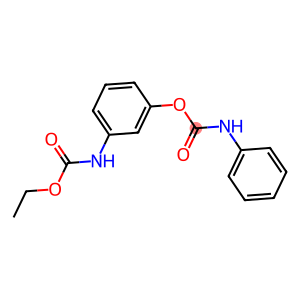

In [169]:
idd = 9
SVG(imgs[idd])

In [170]:
df_curated = pd.DataFrame({'name': name_list,
                           'smiles': smiles_list,
                           'calc_maa': calc_maa_list,
                           'calc_error': any_errors_list,
                           'pred_maa': pred_maa_list,
                           'pred_maa_error': pred_maa_error_list,
                           'DT50val (ph:7)': DT50val_list})

df_curated = df_curated.merge(df_subset[df_subset['id'].isin(name_list)][['id', 'name', 'ref']].rename(columns={'name': 'real_name', 'id': 'name'}), on='name')

print(df_curated.shape[0])
df_curated.head(2)

29


,name,smiles,calc_maa,calc_error,pred_maa,pred_maa_error,DT50val (ph:7),real_name,ref
0,125,CNC(=O)Oc1cccc2c1OC(C)(C)C2,269.073859,True,158.820035,22.028193,24.0,Carbofuran,"EFSA (European Food Safety Authority), 2004a. ..."
1,122,CNC(=O)Oc1cccc2c1OC(C)(C)O2,268.203134,True,156.947214,21.552626,2.0,Bendiocarb,Bendiocarb - WHO Specifications and Evaluation...


In [171]:
df_curated.to_csv(os.path.join(base_dir, 'data/hydrolysis/public_hydrolysis_data_tebes_stevens.csv'), index=False)

# Data from 10.1016/j.jtice.2021.06.045

In [173]:
pkl_files = glob.glob(f'/Users/nicolairee/KU_data/hydrolysis/101016jjtice202106045/*result.pkl')

calc_failed = []
df_res = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    
    d = pd.read_pickle(f)

    if d[0] == 'error':
        calc_failed.append(f)
    else:
        df_res = df_res._append(d[-1], ignore_index=True, sort=False)

print(df_res.shape[0])
print(np.unique(np.concatenate([x[0] for x in df_res.elec_names.tolist()]), return_counts=True))
df_res.head(2)

33
(array(['Ester', 'Michael acceptor', 'double_bond', 'triple_bond'],
      dtype='<U16'), array([32,  1, 63,  2]))


,name,smiles,logkb exp,real name,elec_sites,elec_names,elec_prod_smis,MAA_values,MAA_calc_logs,nuc_sites,nuc_names,nuc_prod_smis,MCA_values,MCA_calc_logs
0,12,COC(C)=O,-0.70,Methyl acetate,"[[2, 4]]","[[Ester, double_bond]]","[[COC(C)(C)[O-], CO[C-](C)OC]]","[[122.79976518661715, -113.80950818804558]]","[[[[None, '12/reac01/conf01/gfn1/12_reac01_con...","[[4, 2, 1]]","[[Ester, double_bond, atom_with_lone_pair]]","[[CO[C+](C)OC, COC(C)(C)[O+], CC(=O)[O+](C)C]]","[[327.995507130865, 139.61969966813922, 259.70...","[[[[None, '12/reac01/conf01/gfn1/12_reac01_con..."
1,15,CC(=O)OCCCl,-0.41,2-chloroethyl acetate,"[[1, 2]]","[[Ester, double_bond]]","[[CC(C)([O-])OCCCl, CO[C-](C)OCCCl]]","[[143.61945420177653, -106.40507920086384]]","[[[[None, '15/reac01/conf08/gfn1/15_reac01_con...","[[2, 1, 3, 6]]","[[Ester, double_bond, atom_with_lone_pair, ato...","[[CO[C+](C)OCCCl, CC(C)([O+])OCCCl, CC(=O)[O+]...","[[323.31234105629846, 141.90979701839387, 258....","[[[[None, '15/reac01/conf08/gfn1/15_reac01_con..."


In [174]:
smarts_of_interest = Chem.MolFromSmarts('[#6X3;$([#6X3][#6]),$([#6X3H]),$([#6X3][OX2H0]):1](=[OX1:2])[#8X2H0:3][#6;!$(C=[O,N,S]):4]') # Ester

logkb_list = []
calc_maa_list = []
pred_maa_list = []
pred_maa_error_list = []

for idx, row in df_res.iterrows():
    logkb = row['logkb exp']
    elec_names = np.array(row['elec_names'][0])
    elec_sites = np.array(row['elec_sites'][0])
    MAA_values = np.array(row['MAA_values'][0])

    smiles = row['smiles']
    rdkit_mol = Chem.MolFromSmiles(smiles)

    if (row['MAA_calc_logs'][0][0][0][0] != None) or (not len(rdkit_mol.GetSubstructMatches(smarts_of_interest))):
        continue

    # Create descriptor vector only for the provided atom sites
    sites_of_interest = np.array(rdkit_mol.GetSubstructMatches(smarts_of_interest))[:,0]

    hashID = hashlib.md5(smiles.encode()).hexdigest()
    elec_sites, elec_names, elec_preds, elec_errors, nuc_sites, nuc_names, nuc_preds, nuc_errors = run_MAA_and_MCA_predictions(hashID, smiles)
    
    pred_maa = []
    pred_maa_error = []
    for atom in sites_of_interest:
        index = elec_sites.index(atom)
        pred_maa.append(elec_preds[index])
        pred_maa_error.append(elec_errors[index])

    index_list = [i for i, val in enumerate(elec_sites) if val in sites_of_interest]
    assert len(index_list) == len(pred_maa), 'Length of predicted and calculated sites are different!'

    maa = MAA_values[index_list]
    if len(maa) == 1:
        logkb_list.append(float(logkb))
        calc_maa_list.append(float(max(maa)))
        pred_maa_list.append(float(max(pred_maa)))
        pred_maa_error_list.append(float(pred_maa_error[np.argmax(pred_maa)]))
    else:
        print(maa, elec_names[index_list])

In [188]:
x = logkb_list
# x = calc_maa_list
y = calc_maa_list
y = pred_maa_list

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

print(f'MSE:\t\t {metrics.mean_squared_error(x, y):.2f}')
print(f'RMSE:\t\t {metrics.mean_squared_error(x, y, squared=False):.2f}')
print(f'MAE:\t\t {metrics.mean_absolute_error(x, y):.2f}')
print(f'R^2:\t\t {r_value**2:.2f}')
print(f'Pearsonr:\t {scipy.stats.pearsonr(x, y).statistic:.2f}')
print(f'SpearmanR:\t {scipy.stats.spearmanr(x, y).statistic:.2f}')

MSE:		 20822.44
RMSE:		 144.30
MAE:		 142.74
R^2:		 0.61
Pearsonr:	 0.78
SpearmanR:	 0.86


In [189]:
# Error above 30 kJ/mol
error_index = np.where(np.array(pred_maa_error_list) > 30)
x2 = np.array(x)[error_index]
y2 = np.array(y)[error_index]
print(max(pred_maa_error_list))

21.61357165317275


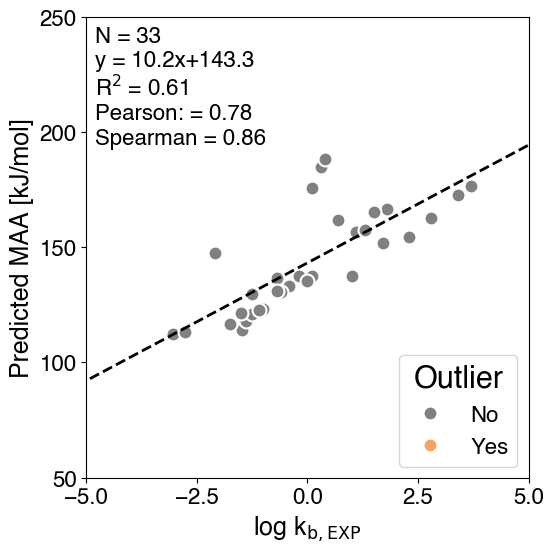

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# sns.set_theme(style='whitegrid')

fig = plt.subplots(figsize=(6, 6))
plt.plot(x, y, 'o', color='Gray',  markeredgecolor='White', markeredgewidth=1.5, markersize=10, label='No')
plt.plot(x2, y2, 'o', color='sandybrown', markeredgecolor='White', markeredgewidth=1.5, markersize=10, label='Yes')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

plt.plot(np.arange(-10,11,1), slope * np.arange(-10,11,1) + intercept, 'Black', linestyle='dashed', lw=2)
plt.text(-4.8, 195, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {scipy.stats.pearsonr(x, y).statistic:.2f} \nSpearman = {scipy.stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)

plt.xlabel(r'log k$_{\mathrm{b, EXP}}$', fontsize=18)
plt.ylabel('Predicted MAA [kJ/mol]', fontsize=18)
# plt.ylabel('Calculated MAA [kJ/mol]', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlim(-5,5)
plt.ylim(50,250)
plt.xticks(np.arange(-5,6,2.5), fontsize=16)
plt.yticks(np.arange(50,251,50), fontsize=16)

plt.legend(loc=4, title='Outlier', fontsize=16)
plt.tight_layout()
# plt.savefig('figures/hydrolysisResultsHilalCalc.pdf')
plt.savefig('figures/hydrolysisResultsHilalPred.pdf')
plt.show()

In [153]:
df_curated = pd.DataFrame({'name': df_res['name'].tolist(),
                           'smiles': df_res['smiles'].tolist(),
                           'calc_maa': calc_maa_list,
                           'calc_error': ['False']*len(calc_maa_list),
                           'pred_maa': pred_maa_list,
                           'pred_maa_error': pred_maa_error_list,
                           'logkb exp': logkb_list,
                           'real_name': df_res['real name'].tolist()})
df_curated

,name,smiles,calc_maa,calc_error,pred_maa,pred_maa_error,logkb exp,real_name
0,12,COC(C)=O,122.799765,False,136.696274,12.217516,-0.70,Methyl acetate
1,15,CC(=O)OCCCl,143.619454,False,133.173643,13.349347,-0.41,2-chloroethyl acetate
2,23,CCOC(=O)C(C)Br,140.762357,False,137.705804,15.917108,1.00,ethyl 2-bromopropionate
3,6,CCOC(=O)C(C)C,115.803594,False,114.086314,13.175893,-1.49,ethyl isobutyrate
4,24,CCOC(=O)CF,150.457429,False,156.771883,15.657808,1.10,Ethyl fluoroacetate
5,1,CCOC(=O)C(C)(C)C,112.444458,False,113.262321,21.613572,-2.80,Ethyl neopentate
6,31,CCOC(=O)C(Cl)(Cl)Cl,221.438940,False,172.694700,17.913712,3.40,Ethyl trichloroacetate
7,14,CC(=O)OC1CC1,140.202939,False,130.593222,14.211417,-0.60,Cyclopropyl acetate
8,13,COCCOC(C)=O,125.003576,False,131.059362,10.961417,-0.69,2-methoxyethyl acetate
9,30,CCOC(=O)C(Cl)Cl,191.405219,False,162.836839,14.140339,2.80,Ethyl dichloroacetate


In [156]:
df_curated.to_csv(os.path.join(base_dir, 'data/hydrolysis/101016jjtice202106045_data.csv'), index=False)

# CAE MLR Tebes Stevens

In [240]:
df_cae = pd.read_pickle('/Users/nicolairee/Desktop/steno/PhD/applications/ESNUEL/hydrolysis/results/maa/stevens_mlr_cae.pkl')
df_cae = df_cae.drop(columns=['Unnamed: 3'])
df_cae['canon_smiles'] = df_cae['SMILES'].apply(lambda smi: Chem.MolToSmiles(Chem.MolFromSmiles(smi)))
print(df_cae.shape)
df_cae.head(2)

(223, 23)


,Name,SMILES,Expt. log(k),pKa OC=O,pKa_macro COOH,pKa_macro OH,SH *COOH,SH *OH,SEI *OH,SEI C=O*,...,μ COOH,AAC,Sum π χ,molec α,molec α OH,canon_smiles,hashcode,MAA_value,elec_site,calc_error
0,Methyl formate,C(=O)OC,1.563,-6.81,4.27,15.78,0.626,0.458,1.000,1.111,...,1.52,0,19.106,5.255,3.209,COC=O,7e60347658bd93ed1fead2241674db39,146.270077,2.0,False
1,Ethyl formate,C(=O)OCC,1.410,-6.82,4.27,16.47,0.626,0.527,1.125,1.127,...,1.52,0,19.142,7.066,5.037,CCOC=O,14733b7b1759a2d39b2b43865a28c745,135.588861,3.0,False


In [258]:
calc_maa_list = []
pred_maa_list = []
pred_maa_error_list = []
logk_exp_list = []

hashID_list = []
smarts_of_interest = Chem.MolFromSmarts('[#6](=[OX1])[#8][#6,#7]')
# smarts_of_interest = Chem.MolFromSmarts('[#6]([#6,#7])(=[OX1])[#8][#6]') # Esters, "Amides"

for idx, row in df_cae[df_cae['calc_error'] == 'False'].drop_duplicates(subset=['canon_smiles'], keep='first').iterrows():
    
    hashID = row['hashcode']
    smiles = row['canon_smiles']
    rdkit_mol = Chem.MolFromSmiles(smiles)

    if not len(rdkit_mol.GetSubstructMatches(smarts_of_interest)):
        continue

    # try:
    #     sites_of_interest = list(set(np.array(rdkit_mol.GetSubstructMatches(smarts_of_interest))[:,0]))
    # except:
    #     display(row)
    #     display(rdkit_mol)
    #     break
    # sites_of_interest = remove_identical_atoms(Chem.AddHs(rdkit_mol), sorted(sites_of_interest))
    sites_of_interest = [int(row['elec_site'])]
    
    try:
        elec_sites, elec_names, elec_preds, elec_errors, nuc_sites, nuc_names, nuc_preds, nuc_errors = run_MAA_and_MCA_predictions(hashID, smiles)
        
        pred_maa = []
        pred_maa_error = []
        for atom in sites_of_interest:
            index = elec_sites.index(atom)
            pred_maa.append(elec_preds[index])
            pred_maa_error.append(elec_errors[index])
    except:
        display(row)
        display(rdkit_mol)
        break

    calc_maa_list.append(float(row['MAA_value']))
    # calc_maa_list.append(float(row['water_affinity']))
    pred_maa_list.append(float(max(pred_maa)))
    pred_maa_error_list.append(float(pred_maa_error[np.argmax(pred_maa)]))
    logk_exp_list.append(float(row['Expt. log(k)']))
    hashID_list.append(hashID)

In [259]:
x = logk_exp_list
y = pred_maa_list

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

print(f'N:\t\t {len(x)}')
print(f'MSE:\t\t {metrics.mean_squared_error(x, y):.2f}')
print(f'RMSE:\t\t {metrics.mean_squared_error(x, y, squared=False):.2f}')
print(f'MAE:\t\t {metrics.mean_absolute_error(x, y):.2f}')
print(f'R^2:\t\t {r_value**2:.2f}')
print(f'Pearsonr:\t {scipy.stats.pearsonr(x, y).statistic:.2f}')
print(f'SpearmanR:\t {scipy.stats.spearmanr(x, y).statistic:.2f}')

N:		 190
MSE:		 24244.51
RMSE:		 155.71
MAE:		 152.60
R^2:		 0.42
Pearsonr:	 0.65
SpearmanR:	 0.71


In [260]:
# Error above 30 kJ/mol
error_index = np.where(np.array(pred_maa_error_list) > 30)
x2 = np.array(x)[error_index]
y2 = np.array(y)[error_index]
print(max(pred_maa_error_list))

28.533458945958493


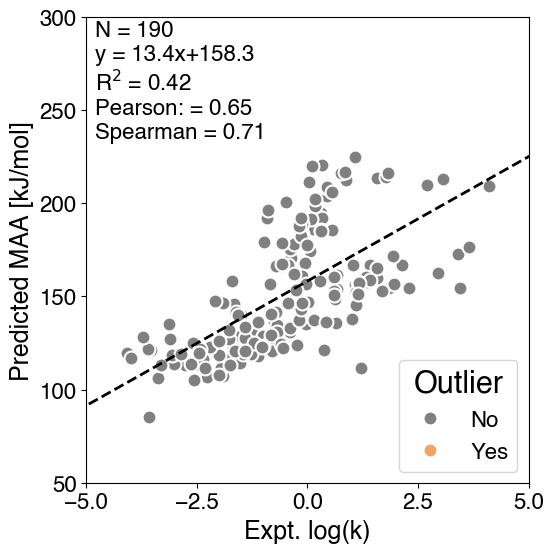

In [261]:
fig = plt.subplots(figsize=(6, 6))
plt.plot(x, y, 'o', color='Gray',  markeredgecolor='White', markeredgewidth=1.5, markersize=10, label='No')
plt.plot(x2, y2, 'o', color='sandybrown', markeredgecolor='White', markeredgewidth=1.5, markersize=10, label='Yes')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

plt.plot(np.arange(-12,13,1), slope * np.arange(-12,13,1) + intercept, 'Black', linestyle='dashed', lw=2)
plt.text(-4.8, 235, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {scipy.stats.pearsonr(x, y).statistic:.2f} \nSpearman = {scipy.stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
# plt.text(-10, 0, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {scipy.stats.pearsonr(x, y).statistic:.2f} \nSpearman = {scipy.stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)

plt.xlabel('Expt. log(k)', fontsize=18)
plt.ylabel('Predicted MAA [kJ/mol]', fontsize=18)
# plt.ylabel('Calculated MAA [kJ/mol]', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlim(-5,5)
plt.ylim(50,300)
plt.xticks(np.arange(-5,6,2.5), fontsize=16)
plt.yticks(np.arange(50,301,50), fontsize=16)
plt.legend(loc=4, title='Outlier', fontsize=16)

plt.tight_layout()
plt.savefig('figures/hydrolysisResultsCAEPred.pdf')
plt.show()

In [262]:
x = logk_exp_list
y = calc_maa_list

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

print(f'N:\t\t {len(x)}')
print(f'MSE:\t\t {metrics.mean_squared_error(x, y):.2f}')
print(f'RMSE:\t\t {metrics.mean_squared_error(x, y, squared=False):.2f}')
print(f'MAE:\t\t {metrics.mean_absolute_error(x, y):.2f}')
print(f'R^2:\t\t {r_value**2:.2f}')
print(f'Pearsonr:\t {scipy.stats.pearsonr(x, y).statistic:.2f}')
print(f'SpearmanR:\t {scipy.stats.spearmanr(x, y).statistic:.2f}')

N:		 190
MSE:		 24979.89
RMSE:		 158.05
MAE:		 154.14
R^2:		 0.52
Pearsonr:	 0.72
SpearmanR:	 0.76


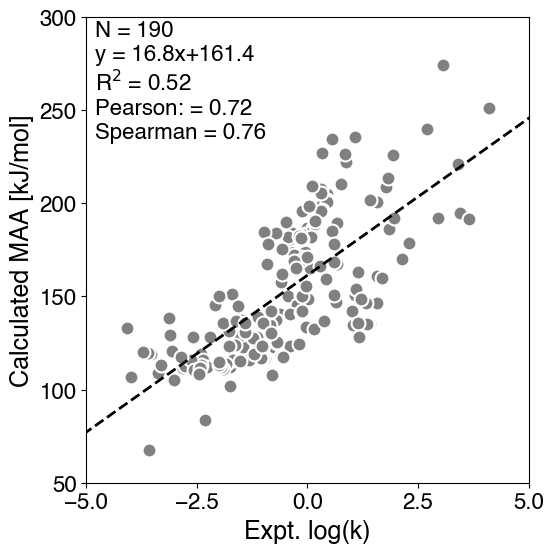

In [263]:
fig = plt.subplots(figsize=(6, 6))
plt.plot(x, y, 'o', color='Gray',  markeredgecolor='White', markeredgewidth=1.5, markersize=10, label='No')
# plt.plot(x2, y2, 'o', color='sandybrown', markeredgecolor='White', markeredgewidth=1.5, markersize=10, label='Yes')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

plt.plot(np.arange(-12,13,1), slope * np.arange(-12,13,1) + intercept, 'Black', linestyle='dashed', lw=2)
plt.text(-4.8, 235, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {scipy.stats.pearsonr(x, y).statistic:.2f} \nSpearman = {scipy.stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)

plt.xlabel('Expt. log(k)', fontsize=18)
# plt.ylabel('Predicted MAA [kJ/mol]', fontsize=18)
plt.ylabel('Calculated MAA [kJ/mol]', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlim(-5,5)
plt.ylim(50,300)
plt.xticks(np.arange(-5,6,2.5), fontsize=16)
plt.yticks(np.arange(50,301,50), fontsize=16)
# plt.legend(loc=4, title='Outlier', fontsize=16)

plt.tight_layout()
plt.savefig('figures/hydrolysisResultsCAECalc.pdf')
plt.show()

In [264]:
df_curated = df_cae[df_cae['calc_error'] == 'False'].drop_duplicates(subset=['canon_smiles'], keep='first')
df_curated = df_curated[df_curated['hashcode'].isin(hashID_list)]
df_curated['pred_maa'] = pred_maa_list
df_curated['pred_maa_error'] = pred_maa_error_list
df_curated = df_curated.rename(columns={'MAA_value': 'calc_maa'})
df_curated['elec_site'] = df_curated['elec_site'].apply(lambda i: int(i))
df_curated

,Name,SMILES,Expt. log(k),pKa OC=O,pKa_macro COOH,pKa_macro OH,SH *COOH,SH *OH,SEI *OH,SEI C=O*,...,Sum π χ,molec α,molec α OH,canon_smiles,hashcode,calc_maa,elec_site,calc_error,pred_maa,pred_maa_error
0,Methyl formate,C(=O)OC,1.563000,-6.81,4.27,15.78,0.626,0.458,1.000,1.111,...,19.106,5.255,3.209,COC=O,7e60347658bd93ed1fead2241674db39,146.270077,2,False,159.985530,17.421653
1,Ethyl formate,C(=O)OCC,1.410000,-6.82,4.27,16.47,0.626,0.527,1.125,1.127,...,19.142,7.066,5.037,CCOC=O,14733b7b1759a2d39b2b43865a28c745,135.588861,3,False,166.967180,14.688333
2,Propyl formate,C(=O)OCCC,1.358000,-6.82,4.27,16.85,0.626,0.545,1.162,1.135,...,19.147,8.889,6.874,CCCOC=O,4b70718e05770a42d2ff0bf4d2c12de2,135.663723,4,False,158.451752,14.686851
3,Butyl formate,C(=O)OCCCC,1.338000,-6.82,4.27,16.95,0.626,0.554,1.178,1.139,...,19.147,10.719,8.715,CCCCOC=O,1ef4346e2a30c14cd012c510fda9c24d,135.400127,5,False,157.706682,15.745706
4,Isopropyl formate,C(=O)OC(C)C,1.037000,-6.82,4.27,17.26,0.626,0.596,1.250,1.142,...,19.181,8.889,6.874,CC(C)OC=O,be4cf88e5269191ec26c2a13083cbbf8,134.688533,4,False,167.139575,13.912386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,n-Butyl palmitate,CCCCCCCCCCCCCCCC(=O)OCCCC,-3.074001,-7.03,4.79,15.78,1.063,0.458,1.000,1.333,...,49.863,20.299,3.209,CCCCCCCCCCCCCCCC(=O)OCCCC,5c008116defc6a399f3c918091872268,120.802304,15,False,118.342721,9.794626
219,Methyl stearate,CCCCCCCCCCCCCCCCCC(=O)OC,-3.318759,-7.03,4.50,15.78,1.006,0.458,1.000,1.319,...,53.327,20.916,3.209,CCCCCCCCCCCCCCCCCC(=O)OC,f5f6a861463af0a20d5c941674f395d3,112.965761,17,False,113.430315,11.492376
220,Octadecyl acetate,CCCCCCCCCCCCCCCCCCOC(=O)C,-0.560667,-7.18,4.73,7.07,1.009,0.707,1.352,1.374,...,107.497,28.060,12.858,CCCCCCCCCCCCCCCCCCOC(C)=O,5042129cddf7641af4a5a01fadbf3b58,117.343077,19,False,122.311968,11.911581
221,Ethyl stearate,CCCCCCCCCCCCCCCCCC(=O)OCC,-4.000000,-7.23,4.55,7.07,1.037,0.707,1.352,1.382,...,107.640,26.220,12.858,CCCCCCCCCCCCCCCCCC(=O)OCC,962542a6d8d3f161166027e58aaebc3d,106.726924,17,False,117.199526,10.557355


In [265]:
df_curated.to_csv(os.path.join(base_dir, 'data/hydrolysis/CAEHydrolysisDataset.csv'), index=False)